In [208]:
%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [209]:
#First import the necessary packages
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
import pymongo
import os
import secrets




In [210]:
#import Max's library to handle interaction with the API
from wrangler import *



In [211]:
#Config for the database connection
def con_sql(db_name, dialect=None):
	db_file = Path(db_name)
	if not db_file.is_file():
		print("no such database file: {}".format(db_name))
		return
	if dialect is None:
		return sqlite3.connect(db_name)
	return sqlite3.connect(db_name, dialect)



In [212]:
#Establish the database connection
conn = sqlite3.Connection('database.sqlite')
c = conn.cursor()



In [213]:
#Connect to the API and provide rainy day dataframe, rainy_df
config, err = load_config("config.json")
if err is not None:
    panic(err)

rainy_df = darksky_days(df, config,"%Y-%m-%d")
print(rainy_df.head())



   Match_ID Div  Season        Date        HomeTeam       AwayTeam  FTHG  \
0      1133  D2    2011  2011-07-15         Cottbus        Dresden     2   
1      1167  D2    2011  2011-07-15  Greuther Furth  Ein Frankfurt     2   
2      1551  D2    2011  2011-07-15   Frankfurt FSV   Union Berlin     1   
3      1550  D2    2011  2011-07-16  Erzgebirge Aue         Aachen     1   
4      1678  D2    2011  2011-07-16        St Pauli     Ingolstadt     2   

   FTAG FTR       Posix Precipitation Type  
0     1   H  1310706000               rain  
1     3   A  1310706000               rain  
2     1   D  1310706000               rain  
3     0   H  1310792400               rain  
4     0   H  1310792400               rain  


In [214]:
#This class holds information about each team
class Team:
    def __init__(self, name):
        self.name = name
        self.record = []
        self.goals_scored = None
        self.game_dates_and_results_list = None
        self.rainy_day_win_percentage = None

    def get_rainy_day_win_percentage(self, rain_df):
    
        rainy_game_list = []
        for game in self.game_dates_and_results_list:
            for index, date in enumerate (rain_df.Date):
                if (game[0] == date) and (rain_df['Precipitation Type'][index]=='rain'):
                    rainy_game_list.append([date, game[1]])
             
        win_count = 0
        for game in rainy_game_list:
            if game[1]=='W':
                win_count+=1
        if len(rainy_game_list)>0:
            self.rainy_day_win_percentage = win_count/len(rainy_game_list)
        else:
            self.rainy_day_win_percentage = 0
            
        
    #Gets a list of tuples of all the dates a team played 
    # and a binary value for whether they won or lost in the format (date, 1) or (date, 0)
    def set_game_dates_and_results_list(self):
        q=("""
        SELECT Date, FTR, HomeTeam, AwayTeam, Season
        FROM Matches 
        WHERE (Season=2011) AND ((HomeTeam='{}') OR (AwayTeam='{}'))
        ORDER BY Date
        """.format(self.name, self.name))

        df = pd.read_sql_query(q, conn)
        date_result_tuple_list = []
        for i, date in enumerate(df.Date):
            if df.FTR[i]=='H' and df.HomeTeam[i]==self.name:
                date_result_tuple_list.append((df.Date[i], 'W'))
            elif df.FTR[i]=='H' and df.HomeTeam[i]!=self.name:
                date_result_tuple_list.append((df.Date[i], 'L'))
            elif df.FTR[i]=='A' and df.AwayTeam[i]==self.name:
                date_result_tuple_list.append((df.Date[i], 'W'))
            elif df.FTR[i]=='A' and df.AwayTeam[i]!=self.name:
                date_result_tuple_list.append((df.Date[i], 'L'))
            else:
                date_result_tuple_list.append((df.Date[i], 'D'))

        self.game_dates_and_results_list = date_result_tuple_list

    #Sets the Team's GOALS SCORED
    def set_goals_scored(self):
        q=("""
        SELECT FTHG, FTAG
        FROM Matches
        WHERE (Season=2011) AND ((HomeTeam='{}') OR (AwayTeam='{}'))
        """.format(self.name, self.name))

        df = pd.read_sql_query(q, conn)
        total_goals = df.FTHG.sum() + df.FTAG.sum()
        self.goals_scored = total_goals

    #Sets the Team's RECORD
    def set_record(self):
        #This finds the wins
        q=("""
        SELECT FTR, HomeTeam, AwayTeam, Season  
        FROM Matches
        WHERE ((Season=2011) AND (HomeTeam='{}')) AND (FTR='H') OR ((Season=2011) AND (AwayTeam='{}')) AND (FTR='A')
        """.format(self.name,self.name))

        wins = pd.read_sql_query(q, conn)
        num_wins = wins.shape[0]

        #This finds the losses
        q=("""
        SELECT FTHG, FTAG, FTR, HomeTeam, AwayTeam, Season  
        FROM Matches
        WHERE ((Season=2011) AND (HomeTeam='{}')) AND (FTR='A') OR ((Season=2011) AND (AwayTeam='{}')) AND (FTR='H')
        """.format(self.name,self.name))

        losses = pd.read_sql_query(q, conn)
        num_losses = losses.shape[0]

        #This finds the drawws
        q=("""
        SELECT FTHG, FTAG, FTR, HomeTeam, AwayTeam, Season  
        FROM Matches
        WHERE ((Season=2011) AND (HomeTeam='{}')) AND (FTR='D') OR ((Season=2011) AND (AwayTeam='{}')) AND (FTR='D')
        """.format(self.name,self.name))

        draws = pd.read_sql_query(q, conn)
        num_draws = draws.shape[0]
        
        record_list = [num_wins,num_losses,num_draws]
        
        self.record.append(num_wins)
        self.record.append(num_losses)
        self.record.append(num_draws)

    def set_name(self, name):
        self.name = name
        




In [215]:
#Gets a list of all the teams that played in the 2011 season
def get_team_list():
        q=("""
        SELECT TeamName  
        FROM Unique_Teams u
        JOIN Matches m
        WHERE (u.TeamName=m.HomeTeam) OR (u.TeamName=m.AwayTeam) AND (m.Season=2011)
        """)
        df = pd.read_sql_query(q, conn)
        df.drop_duplicates('TeamName', inplace=True)
        
        team_name_list = list(df.TeamName)
        team_name_list.remove("M'gladbach")
        team_name_list.remove("M'Gladbach")
        team_name_list.remove("Nott'm Forest")
        
        return team_name_list
    
    
    

In [216]:
#populate a list of teams that played in 2011
team_list = get_team_list()



In [217]:
#populates a list with local variables, one for each team
list_of_team_objects = []
for team in team_list:
    locals()[team.replace(' ', '_')] = Team(team)
    list_of_team_objects.append(locals()[team.replace(' ', '_')])
    
    
    

In [218]:
#for each Team, call methods to populate it's attributes with the desired data
for team in list_of_team_objects:
    team.set_game_dates_and_results_list()
    team.set_record()
    team.set_goals_scored()
    team.get_rainy_day_win_percentage(rainy_df)
    
    

images/Bayern_Munich.png
images/Dortmund.png
images/Leverkusen.png
images/RB_Leipzig.png
images/Schalke_04.png
images/Wolfsburg.png
images/FC_Koln.png
images/Hoffenheim.png
images/Hertha.png
images/Mainz.png
images/Hamburg.png
images/Werder_Bremen.png
images/Ein_Frankfurt.png
images/Augsburg.png
images/Freiburg.png
images/Stuttgart.png
images/Hannover.png
images/Ingolstadt.png
images/Darmstadt.png
images/Paderborn.png
images/Nurnberg.png
images/Braunschweig.png
images/Greuther_Furth.png
images/Fortuna_Dusseldorf.png
images/Kaiserslautern.png
images/St_Pauli.png
images/Bochum.png
images/Karlsruhe.png
images/Bielefeld.png
images/Cottbus.png
images/Duisburg.png
images/Hansa_Rostock.png
images/Aachen.png
images/Union_Berlin.png
images/Heidenheim.png
images/Dresden.png
images/Sandhausen.png
images/Erzgebirge_Aue.png
images/Kiel.png
images/Regensburg.png
images/Munich_1860.png
images/Wurzburger_Kickers.png
images/Frankfurt_FSV.png
images/Aalen.png
images/Oberhausen.png
images/Osnabruck.png
i

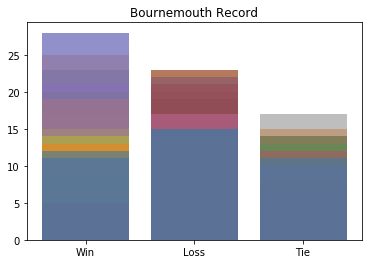

In [219]:
#Populate a list of files paths with win/loss/tie histograms for each team
image_path_list = []
for team in list_of_team_objects:
    objects = ('Win','Loss','Tie')
    performance = [team.record[0], team.record[1], team.record[2]]

    plt.bar(objects, performance, align='center', alpha=0.5)
    plt.xticks(objects)
    plt.title(f'{team.name} Record')

    team_name = team.name.replace(' ','_') +'.png'
    file_name=os.path.join('images', team_name)
    image_path_list.append(file_name)
    print(file_name)
    plt.savefig(file_name)
    
    
    

In [220]:
# objects = ('Win','Loss','Tie')
# performance = [Bayern_Munich.record[0], Bayern_Munich.record[1], Bayern_Munich.record[2]]

# plt.bar(objects, performance, align='center', alpha=0.5)
# plt.xticks(objects)
# plt.ylabel('Number')
# plt.title(f'Win Loss Draw {Bayern_Munich.name}')

# team_name = Bayern_Munich.name.replace(' ','_') +'.png'
# file_name=os.path.join('images', team_name)
# print(file_name)
# plt.show()
# plt.savefig(file_name)



In [221]:
SoccerData2.db_name.drop_collection(SoccerData2.collection_name)


{'ns': 'soccer_db.soccer_collection', 'nIndexesWas': 1, 'ok': 1.0}

In [222]:
#This class interacts with Mongo, establishes a database, and populates a collection
class MongoHandler():
    def __init__(self, db_name, collection_name):
        self.db_name = db_name
        self.collection_name = collection_name
        
        
    def initialize_database(self):
        myclient = pymongo.MongoClient("mongodb://127.0.0.1:27017/")
        self.db_name = myclient[self.db_name]
        self.collection_name = self.db_name[self.collection_name]
    
    def add_records(self, list_of_team_objects, image_path_list):  
        team_records = []
        for index, team in enumerate(list_of_team_objects):
            #if not self.collection_name.find({'name': team.name}):
                team_data = {'name': team.name, 'record': team.record, 'goals_scored': int(team.goals_scored),
                            'win_loss_histgram' : image_path_list[index], 
                             'rainy_day_win_percentage' : team.rainy_day_win_percentage}
                team_records.append(team_data)
        if len(team_records)>=1:
            self.collection_name.insert_many(team_records)
        
    def read_one_record(self, team):
        query_list = []
        query = self.collection_name.find({'name': team.name})
        
        for item in query:
            query_list.append(item)
            
        return query_list
            
    def read_multiple_records(self, list_of_teams):
        list_of_records = []
        for team in list_of_teams:
            list_of_records.append(self.read_one_record(team))

        return list_of_records
    
    def drop_collection(self):
        self.db_name.drop_collection(self.collection_name)
    

        

In [223]:
SoccerData2 = MongoHandler('soccer_db', 'soccer_collection')
SoccerData2.initialize_database()
SoccerData2.add_records(list_of_team_objects, image_path_list)



In [224]:

SoccerData2.read_one_record(secrets.choice(list_of_team_objects))



[{'_id': ObjectId('5cdf349cb6f91e70d4a61179'),
  'name': 'Dortmund',
  'record': [25, 3, 6],
  'goals_scored': 105,
  'win_loss_histgram': 'images/Dortmund.png',
  'rainy_day_win_percentage': 0.5714285714285714}]

In [225]:
SoccerData2.read_multiple_records(list_of_team_objects)




[[{'_id': ObjectId('5cdf349cb6f91e70d4a61178'),
   'name': 'Bayern Munich',
   'record': [23, 7, 4],
   'goals_scored': 99,
   'win_loss_histgram': 'images/Bayern_Munich.png',
   'rainy_day_win_percentage': 0.7305699481865285}],
 [{'_id': ObjectId('5cdf349cb6f91e70d4a61179'),
   'name': 'Dortmund',
   'record': [25, 3, 6],
   'goals_scored': 105,
   'win_loss_histgram': 'images/Dortmund.png',
   'rainy_day_win_percentage': 0.5714285714285714}],
 [{'_id': ObjectId('5cdf349cb6f91e70d4a6117a'),
   'name': 'Leverkusen',
   'record': [15, 10, 9],
   'goals_scored': 96,
   'win_loss_histgram': 'images/Leverkusen.png',
   'rainy_day_win_percentage': 0.27419354838709675}],
 [{'_id': ObjectId('5cdf349cb6f91e70d4a6117b'),
   'name': 'RB Leipzig',
   'record': [0, 0, 0],
   'goals_scored': 0,
   'win_loss_histgram': 'images/RB_Leipzig.png',
   'rainy_day_win_percentage': 0}],
 [{'_id': ObjectId('5cdf349cb6f91e70d4a6117c'),
   'name': 'Schalke 04',
   'record': [20, 10, 4],
   'goals_scored': 118,

In [226]:
usage()




    config, err = load_config("your_config_here.json")
    if err is not None:
        panic(err)

    rainy_df = darksky_days(df, config,"%Y-%m-%d")
    print(rainy_df.head())
    


In [227]:
rainy_df.head()



,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Posix,Precipitation Type
0,1133,D2,2011,2011-07-15,Cottbus,Dresden,2,1,H,1310706000,rain
1,1167,D2,2011,2011-07-15,Greuther Furth,Ein Frankfurt,2,3,A,1310706000,rain
2,1551,D2,2011,2011-07-15,Frankfurt FSV,Union Berlin,1,1,D,1310706000,rain
3,1550,D2,2011,2011-07-16,Erzgebirge Aue,Aachen,1,0,H,1310792400,rain
4,1678,D2,2011,2011-07-16,St Pauli,Ingolstadt,2,0,H,1310792400,rain


In [228]:
rainy_df.dtypes

Match_ID               int64
Div                   object
Season                 int64
Date                  object
HomeTeam              object
AwayTeam              object
FTHG                   int64
FTAG                   int64
FTR                   object
Posix                  int64
Precipitation Type    object
dtype: object